In [2]:
!pip install kaggle-cli

In [3]:
!kg download -u eren42 -p 92kaggleLoL -c imaterialist-challenge-fashion-2018

/root/anaconda3/lib/python3.6/site-packages/mechanicalsoup/browser.py:37: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 37 of the file /root/anaconda3/lib/python3.6/site-packages/mechanicalsoup/browser.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  response.content, **soup_config)
downloading https://www.kaggle.com/c/imaterialist-challenge-fashion-2018/download/test.json.zip

test.json.zip 100% |################################| Time: 0:00:00   1.0 MiB/s

downloading https://www.kaggle.com/c/imaterialist-challenge-fashion-2018/download/validation.json.zip

validation.json.zip 100% |##########################| Time: 0:00:00 532.7 KiB/s

d

In [4]:
!ls

Atelier-CV3.ipynb	   test.json.zip   validation.json.zip
sample_submission.csv.zip  train.json.zip  wish.ipynb


In [5]:
!unzip train.json.zip

Archive:  train.json.zip
  inflating: train.json              


In [6]:
!ls

Atelier-CV3.ipynb	   test.json.zip  train.json.zip       wish.ipynb
sample_submission.csv.zip  train.json	  validation.json.zip


In [8]:
!python download.py train.json train

100%|█████████████████████████████████████| 10000/10000 [05:26<00:00, 30.27it/s]


In [16]:
import os

imgLst = os.listdir('./train/')
nbTrain = len(imgLst)
print (nbTrain)

10000


In [17]:
import json
from pprint import pprint

with open('train.json') as f:
    data = json.load(f)

In [18]:
#labelId qui correspond au label de chaque images
#imageId qui correspond à l'id de l'image dans le dataset
print (data['annotations'][5])

{'labelId': ['190', '106', '53', '153', '164', '184'], 'imageId': '6'}


In [20]:
import pandas as pd

df = pd.DataFrame()
df = pd.read_csv('labels.csv')

In [21]:
# list of tags, labels and booleans 
tags = list(df['Unnamed: 0'].values)
lbls = list(df['labels'].values)

In [68]:
# print (type(tags[1]))
# print (lbls)

In [13]:
img_to_tags = {int(dic['imageId']):list(map(int, dic['labelId']))
               for ind, dic in enumerate(data['annotations'])
                if ind < nbTrain}

In [39]:
tag_to_imgs = {}

In [43]:
for tag in tags:
    keyLst = []
    for key, value in img_to_tags.items():
        if tag in value:
            keyLst.append(key)
    tag_to_imgs[tag] = keyLst

In [42]:
import tensorflow as tf
print (tf.__version__)

1.12.0


In [33]:
import pandas as pd
import json
import matplotlib
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os
from PIL import ImageFile
from tqdm import tqdm
import h5py
import keras
import keras.backend as K
from keras.models import Model
from keras import optimizers
from sklearn.manifold import TSNE
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras import backend as K
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, \
    GlobalMaxPool2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.backend.tensorflow_backend import set_session
from collections import defaultdict
import time
from PIL import Image
from functools import partial
import functools
import cv2 as cv
%pylab inline
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.utils import multi_gpu_model

from PIL import Image

from DataGenerator import *
from metrics import *

Populating the interactive namespace from numpy and matplotlib


/root/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [34]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [44]:
# imgPath list of path per image 
imgsPath = ['./train/{}.jpg'.format(key)
            for key, value in img_to_tags.items()
            if len(value) > 0]
# tagsImg list[list] of tags  
tagsImg = [value for key, value in img_to_tags.items()
           if len(value) > 0]

In [45]:
print ('number of images: {}\nnumber of tags list: {}'
       .format(len(imgsPath),len(tagsImg)))

number of images: 10000
number of tags list: 10000


In [46]:
# errImg file which contains the list of images where we can get the shape
df3 = pd.read_csv('errImg.csv')
err = df3['error'].values
pos = df3['position'].values

In [47]:
print ('number of conflicting file {}'.format(len(err)))

number of conflicting file 291


In [49]:
tagsImg = [x for ind, x in enumerate(tagsImg)
           if imgsPath[ind] not in err]
imgsPath = [x for x in imgsPath
            if x not in err]

In [51]:
#pour voir l'id maximum 
ma = 0
for img in imgsPath:
    nb = int(img.replace('./train/', '').replace('.jpg', ''))
    if nb > ma:
        ma = nb

In [52]:
print ('the maximum image id {}'.format(ma))

the maximum image id 10000


In [53]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

mlb = MultiLabelBinarizer()
cat_tag = mlb.fit_transform(tagsImg)

In [54]:
for i in range(0, 3):
    print (tagsImg[i], cat_tag[i])

[95, 66, 137, 70, 20] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[36, 66, 44, 214, 105, 133] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[170, 66, 97, 153, 105, 138] [0 0 0 0 0 0 0 0 0 0 0 

In [56]:
(X_train, X_test, y_train, y_test) = train_test_split(imgsPath,
                                                      cat_tag,
                                                      test_size=0.1,
                                                      random_state=42)

In [57]:
# EarlyStopping and ReduceLROnPlateau or LearningRateScheduler 
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=[224, 224, 3])

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

/root/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [58]:
batch_size = 128

print ('number of classes: {}'.format(len(mlb.classes_)))

from keras.metrics import top_k_categorical_accuracy

with tf.device("/cpu:0"):
    model = Model(inputs=base_model.input, outputs=predictions)
print('number of layers : ' + str(len(model.layers)))

for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.momentum = 0.8
    
for layer in model.layers[:-20]:
    layer.trainable = False
    
model.compile(optimizer=keras.optimizers.adamax(lr=1e-2),
              loss = 'binary_crossentropy',
              metrics = [fmeasure, recall, precision])

index = 0
while (True):
    if not os.path.exists('logs/' + str(index)):
        os.makedirs('logs/' + str(index))
        break ;
    index += 1
    
logsName = './logs/wish' + str(index) # replace index by the name you want
tensorboard = keras.callbacks.TensorBoard(log_dir=logsName, 
                                          histogram_freq=0, 
                                          batch_size=batch_size, 
                                          write_graph=True, 
                                          write_grads=True, 
                                          write_images=True, 
                                          embeddings_freq=0,
                                          embeddings_layer_names=None, 
                                          embeddings_metadata=None)

number of classes: 221
number of layers : 178


In [59]:
params = {
            'dim': (224,224,3),
            'batch_size': 32,
            'n_classes': len(mlb.classes_),
            'n_channels': 3,
            'shuffle': True
         }
training_generator = DataGenerator(X_train, y_train, **params)
validation_generator = DataGenerator(X_test, y_test, **params)

In [60]:
epochs = 1
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=3,
                    epochs=epochs,
                    callbacks=[tensorboard])

Epoch 1/1


/root/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/root/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/root/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/root/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

280/281 [============================>.] - ETA: 0s - loss: 0.0820 - fmeasure: 0.3552 - recall: 0.2384 - precision: 0.7505

/root/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/root/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/root/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


281/281 [==============================] - 88s 314ms/step - loss: 0.0820 - fmeasure: 0.3552 - recall: 0.2385 - precision: 0.7500 - val_loss: 0.0827 - val_fmeasure: 0.3907 - val_recall: 0.2722 - val_precision: 0.6940


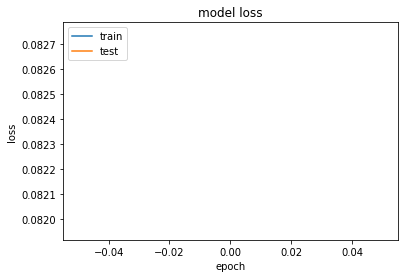

In [61]:
# historique pour la loss function
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [62]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation